In [17]:
import cv2
import numpy as np
import io
import os
from matplotlib import pyplot as plt
# Clustering THETAs of the Google boxes
from scipy.cluster.hierarchy import ward, fcluster
from scipy.spatial.distance import pdist

from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import pairwise_distances


# Set printing options
np.set_printoptions(precision=2, floatmode='fixed', suppress=True)

# Imports the Google Cloud client library
from google.cloud import vision
from google.cloud.vision import types

def plot_img(img, show = True):

    fig = plt.figure(figsize = (8,6))
    plt.imshow(img, interpolation = 'none')
    #plt.imshow(img, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    if show:
        plt.show()

google_res = {}

In [261]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "C:\\Users\\DenisStark\\AndroidStudioProjects\\biblosphere\\python.json"

# Instantiates a client
client = vision.ImageAnnotatorClient()

# The name of the image file to annotate
IMAGEFILE = "shelves/11.jpg"

# Loads the image into memory
with io.open(IMAGEFILE, 'rb') as image_file:
    content = image_file.read()

image = types.Image(content=content)

# Performs label detection on the image file
#response = client.label_detection(image=image)
#labels = response.label_annotations
response = client.document_text_detection(image=image)
google_res[IMAGEFILE] = response

#print('Response:', response)

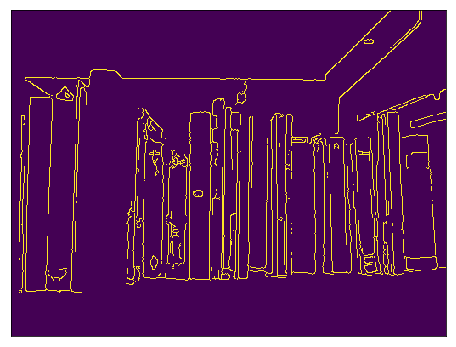

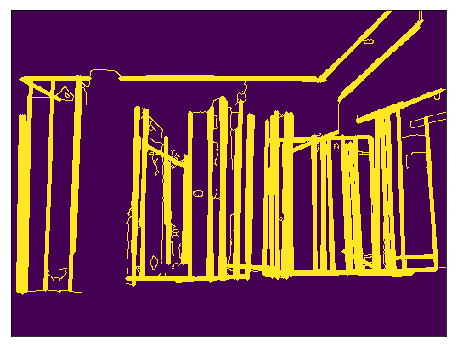

Perpendiculars weight:  [256.00 259.00 199.00 195.00 259.00 144.00 217.00  79.00 217.00 144.00]


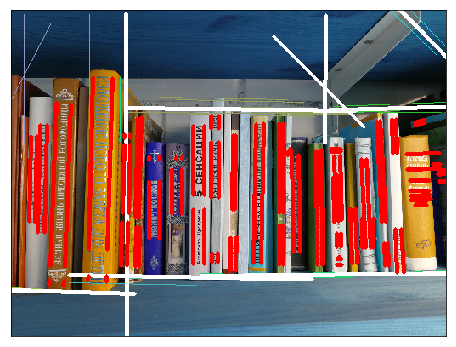

(51, 5) (21, 5)
min, avg, median, max:  2.842170943040401e-14 93.2208949560217 77.51632004770376 249.12848090894786
min, avg, median, max:  101.01980003939822 176.9828258138811 189.03512515123776 249.12848090894786


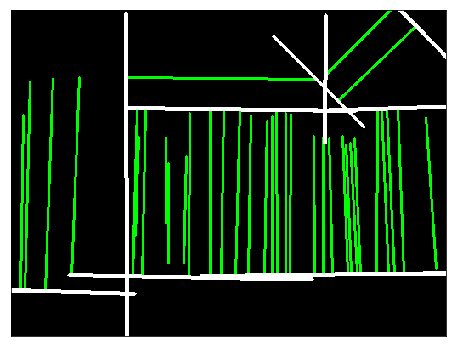

[3 3 2 3 1 2 2 3 3 3 2 1 3 1 2 3 3 3 2 2 3 3 3 2 3 2 3 2 3 3 3 3 3 3 2]


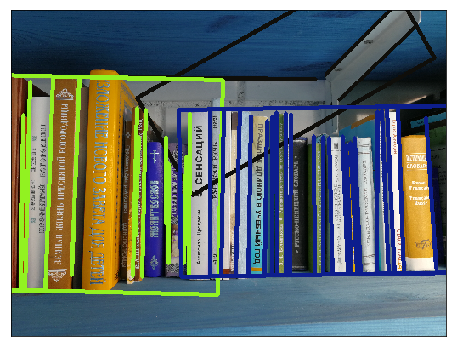

In [338]:
IMAGEFILE = "shelves/6.jpg"
response = google_res[IMAGEFILE]

# Blurring parameters
S_BLUR=5 # works for (9) not good for 13/14
S_BLUR_ALL=15 # works for (9) not good for 13/14

# Canny edges threshold one and two
S_CANNY_TH1=10  # best
S_CANNY_TH2=200  # best
S_HOUGH_TR=80 # best
# Parameters to identify segment of lines after HoughLine search:
# Minimum DBSCAN_MIN_SAM points in the DBSCAN_EPS distance in the line of width S_WIDTH 
# to consider it part of the line segment
S_WIDTH = 3 #best
DBSCAN_EPS=22 # best
DBSCAN_MIN_SAM=30 # best

# Parameters to filter noise segments after identifying segments 
# Keep only segments longer than S_MINLEN points and only segments with less 
# than S_INTERSEC intersections with other segments. Segments with angle more 
# than S_K_ANGLE are not connected
S_MINLEN = 50 # best
S_INTERSEC=3 #best
S_K_ANGLE = 0.02 * np.pi # best

# Parameters to group segments into blocks of books stack together
S_PAR = 0.03 * np.pi
S_BOOKWIDTH = 0.25
S_OVERLAP = 0.9
S_RHO_EXT = 0.2
S_TOOBIG = 3 # best

# Parameters to group perpendiculars
S_K_THETA = 350 #best
S_K_RHO = 4 #best
S_K_EPS = 1 #best

# Parameters to group final segments
S_K2_THETA = 100 #best
S_K2_RHO = 1 #best
S_K2_EPS = 1.6 #best
S_PERPLEN=150 #best

oimg = cv2.imread(IMAGEFILE)
ratio = 512/oimg.shape[1]
img = cv2.resize(oimg, dsize=(0, 0), fx=ratio, fy=ratio)
imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(imgray, (S_BLUR_ALL, S_BLUR_ALL), 0)

boxes = []
segms = []
for p in response.full_text_annotation.pages:
    for b in p.blocks:
        for par in b.paragraphs:
            #for w in par.words:
                #v = w.bounding_box.vertices
                v = par.bounding_box.vertices
                x1, y1 = int(v[0].x * ratio), int(v[0].y * ratio)
                x2, y2 = int(v[1].x * ratio), int(v[1].y * ratio)
                x3, y3 = int(v[2].x * ratio), int(v[2].y * ratio)
                x4, y4 = int(v[3].x * ratio), int(v[3].y * ratio)
                boxes.append([[x1, y1], [x2, y2], [x3, y3], [x4, y4]])
                segms.append(SegmToCartesian([x1, y1], [x2, y2], weight=10000))
                #segms.append(SegmToCartesian([x2, y2], [x3, y3]))
                segms.append(SegmToCartesian([x3, y3], [x4, y4], weight=10000))
                #segms.append(SegmToCartesian([x4, y4], [x1, y1]))
        
boxes = np.array(boxes)
segms = np.array(segms)

mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
color = 1
cv2.drawContours(mask, boxes, -1, color, -1)

imgray = imgray * (1-mask) + blurred * mask
blurred = cv2.GaussianBlur(imgray, (S_BLUR, S_BLUR), 0)
edges = cv2.Canny(blurred, S_CANNY_TH1, S_CANNY_TH2)

# Get the set of THETAs for boxes
    #AA = euclidean_distances(segms[:, 0], metric=SectIntersectionAll)
    #AA = (1 - AA) * 2
    #db = DBSCAN(eps=1, min_samples=2, metric="precomputed").fit(AA)
    #Z = db.labels_

# Show boxes
timg = np.copy(edges)
#cv2.drawContours(timg, boxes, -1, 128, 3)
plot_img(timg, show=True)

Z, boxes = FindClusters(segms, trace=False)
clusters = np.unique(Z)

timg = np.copy(img)
color = (0, 255, 0)
for s in segms[Z==-1]:
        theta, rho, eps, delta = s[0:4]
        x1, y1 = FromCartesian(theta, rho, eps - delta/2)
        x2, y2 = FromCartesian(theta, rho, eps + delta/2)
        cv2.line(timg, (x1, y1), (x2, y2), color, 1)

for c in range(0, max(clusters)+1):  
    color = (np.random.randint(0, 255), np.random.randint(0, 255), np.random.randint(0, 255))
    for s in segms[Z==c]:
        theta, rho, eps, delta = s[0:4]
        x1, y1 = FromCartesian(theta, rho, eps - delta/2)
        x2, y2 = FromCartesian(theta, rho, eps + delta/2)
        cv2.line(timg, (x1, y1), (x2, y2), color, 3)

    cv2.drawContours(timg, [boxes[c]], 0, color, 3)
        
#plot_img(timg, show=True)

theta = np.copy(segms[:, 0])
theta[theta > np.pi* 0.625] = theta[theta > np.pi* 0.625] - np.pi

Z = ward(pdist(theta.reshape(-1, 1)))
Z = fcluster(Z, 0.1 * np.pi, criterion='distance')
t_clust, t_count = np.unique(Z, return_counts=True)
#print('Couters: ', t_count)
#print('Number of clusters: ', len(t_clust), np.sum(t_count > 4))

#timg = np.copy(edges)
for t in t_clust[t_count > 4]:
    #color = (np.random.randint(0, 255), np.random.randint(0, 255), np.random.randint(0, 255))
    color = 128 + int(np.average(segms[Z == t][:,0]) / np.pi * 128)
    for s in segms[Z == t]:
        theta, rho, eps, delta = s[0:4]
    
        x1, y1 = FromCartesian(theta, rho, eps - delta/2)
        x2, y2 = FromCartesian(theta, rho, eps + delta/2)
        #print((x1, y1), (x2, y2))
        cv2.line(timg, (x1, y1), (x2, y2), color, 10)

# Find lines around these THETAs
# Find line segments along the lines
# Group line segments into blocks of books with similar direction
# Cut blocks into the individual books, validate by Google text boxes 

#im_color = cv2.applyColorMap(timg, cv2.COLORMAP_HSV)
#im_color = cv2.applyColorMap(timg, cv2.COLORMAP_RAINBOW)
#im_color = cv2.applyColorMap(timg, cv2.COLORMAP_OCEAN)
#plot_img(im_color, show=True)

keys = get_contours(edges, segms, trace=True)

#print('Segments found: ', len(keys), keys.shape)

#print('Weight (min, avg, max): ', np.amin(keys[:,4]), np.average(keys[:,4]), np.amax(keys[:,4]))
#keys = keys[(keys[:,4] < 800) & (keys[:,4] > 100)] # Fantastic for img12, 13
#keys = keys[(keys[:,4] < 250) & (keys[:,4] > 60)] # Fantastic for img12, 13

# Find perpendiculars groupped and text lines
timg = np.copy(img)
perps = Perpendiculars(keys)

# Only show perpendiculars which does not cross text lines
AA = pair_distance(segms, perps, metric=SectIntersectionSym)
isects = sum(AA)

k = np.copy(perps[isects == 0])
k[:, 1][k[:, 0] > np.pi* 0.625] = - k[:, 1][k[:, 0] > np.pi* 0.625]
k[:, 0][k[:, 0] > np.pi* 0.625] = k[:, 0][k[:, 0] > np.pi* 0.625] - np.pi
k[:, 0] = k[:, 0] * S_K_THETA
k[:, 1] = k[:, 1] * S_K_RHO
k[:, 2] = k[:, 2] * S_K_EPS

Zp = ward(pdist(k[:, 0:3]))
Zp = fcluster(Zp, 310, criterion='distance')

# Set of merged perpendiculars
merged_perps = np.empty((0, 5))
for i in np.unique(Zp):
    merged_perps = np.append(merged_perps, np.reshape(MergePerps(perps[isects == 0][Zp==i], segms), (1,5)), axis=0)

print('Perpendiculars weight: ', merged_perps[:,4])
merged_perps = merged_perps[merged_perps[:,4] > 100]

# Show results
for i in np.unique(Zp):
    color = (np.random.randint(0, 255), np.random.randint(128, 255), np.random.randint(0, 255))
    for p in perps[isects == 0][Zp==i]:
        theta, rho, eps, delta = p[0:4]
        x1, y1 = FromCartesian(theta, rho, eps - delta/2)
        x2, y2 = FromCartesian(theta, rho, eps + delta/2)
        cv2.line(timg, (x1, y1), (x2, y2), color, 1)

color = (255, 255, 255)
for p in merged_perps:
    theta, rho, eps, delta = p[0:4]
    x1, y1 = FromCartesian(theta, rho, eps - delta/2)
    x2, y2 = FromCartesian(theta, rho, eps + delta/2)
    cv2.line(timg, (x1, y1), (x2, y2), color, 3)

color = (255, 0, 0)
for s in segms:
    theta, rho, eps, delta = s[0:4]
    x1, y1 = FromCartesian(theta, rho, eps - delta/2)
    x2, y2 = FromCartesian(theta, rho, eps + delta/2)
    cv2.line(timg, (x1, y1), (x2, y2), color, 3)

# Show groupped perpendiculars and text lines
plot_img(timg, show=True)

# Cut the line segments which cross perpendiculars
AA = pair_distance(merged_perps, keys, metric=SectIntersectionSym)
isects = sum(AA)

lines_to_cut = np.nonzero(isects > 0)

new_lines = np.empty((0, 5))
for i in lines_to_cut[0]:
    new_lines = np.append(new_lines, CutLine(keys[i], merged_perps[AA[:, i] != 0]), axis = 0)

print(new_lines.shape, keys[isects == 0].shape)
keys = np.append(new_lines, keys[isects == 0], axis = 0)

print('min, avg, median, max: ', np.amin(keys[:, 3]), np.average(keys[:, 3]), np.median(keys[:, 3]), np.amax(keys[:, 3]))
book_height = np.average(keys[:, 3])
no_trim = keys[:, 3] > book_height
#no_trim = keys[:, 3] > 100
#print(len(keys), np.sum(no_big))
keys = keys[no_trim]
print('min, avg, median, max: ', np.amin(keys[:, 3]), np.average(keys[:, 3]), np.median(keys[:, 3]), np.amax(keys[:, 3]))

timg = np.zeros(img.shape, dtype = np.uint8)
color = (0, 255, 0)
for s in keys:
        theta, rho, eps, delta = s[0:4]
        x1, y1 = FromCartesian(theta, rho, eps - delta/2)
        x2, y2 = FromCartesian(theta, rho, eps + delta/2)
        cv2.line(timg, (x1, y1), (x2, y2), color, 2)

color = (255, 255, 255)
for p in merged_perps:
    theta, rho, eps, delta = p[0:4]
    x1, y1 = FromCartesian(theta, rho, eps - delta/2)
    x2, y2 = FromCartesian(theta, rho, eps + delta/2)
    cv2.line(timg, (x1, y1), (x2, y2), color, 3)

# Show line segments with cutting perpendiculars
plot_img(timg, show=True)

Z1, boxes = FindClustersWard(keys, 400, trace=False)
#Z1, boxes = FindClusters(keys, trace=False)
clusters = np.unique(Z1)

timg = np.copy(img)
#for s in keys:
#    color = (np.random.randint(0, 255), np.random.randint(0, 255), np.random.randint(0, 255))
#    theta, rho, eps, delta = s[0:4]
#    x1, y1 = FromCartesian(theta, rho, eps - delta/2)
#    x2, y2 = FromCartesian(theta, rho, eps + delta/2)
#    cv2.line(timg, (x1, y1), (x2, y2), color, 3)

#Code for DBSCAN clasters
#color = (0, 255, 0)
#for s in keys[Z1==-1]:
#        theta, rho, eps, delta = s[0:4]
#        x1, y1 = FromCartesian(theta, rho, eps - delta/2)
#        x2, y2 = FromCartesian(theta, rho, eps + delta/2)
#        cv2.line(timg, (x1, y1), (x2, y2), color, 3)

#for c in range(0, max(clusters)+1):  
#    color = (np.random.randint(0, 255), np.random.randint(0, 255), np.random.randint(0, 255))
#    for s in keys[Z1==c]:
#        theta, rho, eps, delta = s[0:4]
#        x1, y1 = FromCartesian(theta, rho, eps - delta/2)
#        x2, y2 = FromCartesian(theta, rho, eps + delta/2)
#        cv2.line(timg, (x1, y1), (x2, y2), color, 3)

#    cv2.drawContours(timg, [boxes[c]], 0, color, 3)

# Code for WARD clusters
for c in range(1, max(clusters)+1):  
    color = (np.random.randint(0, 255), np.random.randint(0, 255), np.random.randint(0, 255))
    for s in keys[Z1==c]:
        theta, rho, eps, delta = s[0:4]
        x1, y1 = FromCartesian(theta, rho, eps - delta/2)
        x2, y2 = FromCartesian(theta, rho, eps + delta/2)
        cv2.line(timg, (x1, y1), (x2, y2), color, 3)
    cv2.drawContours(timg, [boxes[c-1]], 0, color, 3)
        
plot_img(timg, show=True)

In [320]:
def FromCartesian(theta, rho, eps):
    if theta < 0:
        theta = theta + np.pi
        
    if theta > np.pi * 0.625:
        eps = - eps

    x = - eps * np.sin(theta) + rho * np.cos(theta)
    y = eps * np.cos(theta) + rho * np.sin(theta)
    return int(x), int(y)

def SegmToCartesian(pt_start, pt_end, weight=0):
    x1, y1, x2, y2 = pt_start[0], pt_start[1], pt_end[0], pt_end[1]
    if y2 == y1:
        theta = np.pi * 0.5
    else:
        theta = np.arctan((x2-x1)/(y1-y2))
    
    if theta < 0:
        theta = theta + np.pi

    rho = x1 * np.cos(theta) + y1 * np.sin(theta) 
    
    if theta <= np.pi * 0.25:
        eps = (y1 + y2)/2/np.cos(theta) - rho * np.tan(theta)
    elif theta <= np.pi * 0.625:
        eps = rho / np.tan(theta) - (x1 + x2)/2/np.sin(theta)
    else:
        eps = rho * np.tan(theta) - (y1 + y2)/2/np.cos(theta)
    
    # Length of the section
    delta = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    if delta < 1:
        delta = 1
    return [theta, rho, eps, delta, weight]

def BoxSegments(segm):
    t, r, e, d = np.copy(segm[:,0]), np.copy(segm[:,1]), np.copy(segm[:,2]), np.copy(segm[:,3])
    
    t[t > np.pi * 0.625 ] = t[t > np.pi * 0.625 ] - np.pi
    r[t < 0] = -r[t < 0]
    
    theta = np.average(t)

    rho_min = np.amin(r * np.cos(theta - t) + e * np.sin(theta - t))
    rho_max = np.amax(r * np.cos(theta - t) + e * np.sin(theta - t))
    #print('RHO:', rho_min, rho_max)

    eps = - np.sin(theta - t) * r + e * np.cos(theta - t)
    delta = abs(d * np.cos(theta - t))

    #print('EPS: ', eps)
    #print('DELTA: ', delta)

    mi = np.amin(eps - delta/2)
    ma = np.amax(eps + delta/2)

    # Extend along rho axis for the S_RHO_EXT of book height
    delta_avg = np.average(delta)
    rho_min = rho_min - delta_avg * S_RHO_EXT
    rho_max = rho_max + delta_avg * S_RHO_EXT
    
    if theta < 0:
        theta = theta + np.pi
        rho_min = -rho_min
        rho_max = -rho_max

    x1, y1 = FromCartesian(theta, rho_min, mi)
    x2, y2 = FromCartesian(theta, rho_min, ma)
    x3, y3 = FromCartesian(theta, rho_max, ma)
    x4, y4 = FromCartesian(theta, rho_max, mi)

    box = np.int32(np.array([[x1, y1], [x2, y2], [x3,y3], [x4, y4]]))

    return box


# Return 1 if line segments has an intersection, 0 otherwise
def StackedBooks(s1, s2):
    t1, r1, e1, d1 = s1[0:4]
    t2, r2, e2, d2 = s2[0:4]
    
    if t2 > np.pi * 0.625:
        t2 = t2 - np.pi
        r2 = - r2
        
    if t1 > np.pi * 0.625:
        t1 = t1 - np.pi
        r1 = - r1

    # If not nearly parrallel it can't be a neighbouring books 
    if abs(t1 - t2) > S_PAR:
        #print('Angles: ', t1, t2)
        return 0
    
    # Check distance between segments if more than width of one book then disconnected 
    dist = abs(r1 / np.cos(t2 - t1) - r2 + np.tan(t2 - t1) * e2)
    if dist > max(d1, d2) * S_BOOKWIDTH:
        #print('Distance: ', dist, (r1 / np.cos(t2 - t1), r2, np.tan(t2 - t1) * e2))
        return 0
    
    e1p = - np.sin(t2 - t1) * r1 + e1 * np.cos(t2 - t1)
    d1p = abs(d1 * np.cos(t2 - t1))
    
    overlap = min(max((d2 + d1p)/2 - abs(e2 - e1p), 0), d2, d1p)/min(d2, d1p)
    if overlap < S_OVERLAP:
        #print('Overlap: ', overlap)
        return 0

    return 1


def FindClusters(sections, trace=False):
    
    # Find connectedline segment to group
    AA = pairwise_distances(sections, metric=StackedBooks)
    AA = (1 - AA) * 2
    db = DBSCAN(eps=1, min_samples=2, metric="precomputed").fit(AA)
    Z = db.labels_
    
    #keys = np.zeros((sections.shape[0], 4))
    #keys[:,0] = sections[:,0]
    #keys[:,0][keys[:,0] > 0.625 * np.pi] = keys[:,0][keys[:,0] > 0.625 * np.pi] - np.pi
    #keys[:,0] = S_K_THETA * keys[:,0]
    #keys[:,1] = S_K_RHO * np.abs(sections[:,1])
    #keys[:,2] = S_K_EPS * sections[:,2]
    #keys[:,3] = S_K_DEL * sections[:,3]

    #Z = ward(pdist(keys))
    #Z = fcluster(Z, 600, criterion='distance')
    
    if trace:
        print('Cluster vector: ',Z)

    clusters = np.unique(Z)
    boxes = []
    for c in range(0, max(Z)+1):
        box = BoxSegments(sections[Z==c])
        boxes.append(box)

    return Z, np.array(boxes)

def FindClustersWard(sections, distance, trace=False):
    
    k = np.copy(sections)
    k[:, 1][k[:, 0] > np.pi* 0.625] = - k[:, 1][k[:, 0] > np.pi* 0.625]
    k[:, 0][k[:, 0] > np.pi* 0.625] = k[:, 0][k[:, 0] > np.pi* 0.625] - np.pi
    k[:, 0] = k[:, 0] * S_K2_THETA
    k[:, 1] = k[:, 1] * S_K2_RHO
    k[:, 2] = k[:, 2] * S_K2_EPS

    Z = ward(pdist(k[:, 0:3]))
    Z = fcluster(Z, distance, criterion='distance')

    print(Z)
    
    clusters = np.unique(Z)
    boxes = []
    for c in range(1, max(clusters)+1):
        box = BoxSegments(sections[Z==c])
        boxes.append(box)

    return Z, np.array(boxes)


def get_contours(img, text_lines, textlines=False, trace=False):
    # Resize to 512 if larger
    #if img.shape[1] > 512:
    #    ratio = 512/img.shape[1]
    #    img = cv2.resize(img, dsize=(0, 0), fx=ratio, fy=ratio)
    #imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #Best for now
    #blurred = cv2.GaussianBlur(imgray, (S_BLUR, S_BLUR), 0)
    #edges = cv2.Canny(blurred, S_CANNY_TH1, S_CANNY_TH2)
    #edges = img
    lines = cv2.HoughLines(img, 1, np.pi / 180, 80)

    keys = FindSegments(lines, img)

    if trace:
        timg = np.copy(edges)
        color = 255
        for p in keys:
            theta, rho, eps, delta = p[0:4]
            x1, y1 = FromCartesian(theta, rho, eps - delta/2)
            x2, y2 = FromCartesian(theta, rho, eps + delta/2)
            cv2.line(timg, (x1, y1), (x2, y2), color, 3)
        plot_img(timg, show=True)

    # Join contour lines and text lines 
    if textlines:
        all_lines = np.append(keys, text_lines, axis=0)
    else:
        all_lines = keys

    # Find number of intersections for each line segment using asymmetric distance
    AA = pair_distance(all_lines, all_lines, metric=SectIntersection)
    isects = sum(AA)
    keys = all_lines[isects < S_INTERSEC]

    # Find number of intersections for each line segment using symmetric distance
    AA = pairwise_distances(keys, metric=SectIntersection)
    isects = sum(AA)
    keys = keys[isects < S_INTERSEC]

    # First group then filter intersections
    # Find connected line segment to group
    AA = pairwise_distances(keys, metric=SectIntersectionAll)
    AA = (1 - AA) * 2
    db = DBSCAN(eps=1.1, min_samples=2, metric="precomputed").fit(AA)
    Z = db.labels_

    # Size of array for keys for filtered segments. Number of ungroupped (-1) plus 
    # number of groups
    ungrouped, groups = np.sum(Z == -1), np.amax(Z) + 1
    
    filt_seg = np.zeros((ungrouped + groups, 5))
    filt_seg[0:ungrouped, :] = keys[Z == -1]
    
    for i in range(0, np.amax(Z)+1):  
        filt_seg[ungrouped+i, :] = MergeSegments(keys[Z == i])
        
    keys = filt_seg
        
    return keys


def FindSegments(lines, img):
    h, w = img.shape[0:2]
    keys = []
    for l in lines:
        rho, theta = l[0]
        x1, y1, x2, y2 = 0, 0, 0, 0
        # Process separetely lines near horizontal and vertical 
        # to avoid division to near 0
        if np.pi * 0.25 < theta < np.pi * 0.75:
            x1, y1 = 0, int(rho / np.sin(theta))
            x2, y2 = w - 1, int(y1 - w * np.tan(0.5 * np.pi - theta))
        else:
            x1, y1 = int(rho / np.cos(theta)), 0
            x2, y2 = int(x1 - h * np.tan(theta)), h - 1
        
        # find intercestion between line and image borders
        res, (x1, y1), (x2, y2) = cv2.clipLine((0, 0, w-2, h-2), (x1, y1), (x2, y2))
        
        if np.pi * 0.25 < theta < np.pi * 0.75:
            pts = np.zeros(((x2-x1+1)*S_WIDTH, 2), dtype=int)
            x = np.arange(x1, x2+1)
            #print('X: ', x)
            y = np.uint(np.around((x - x1) * (y2 - y1) / (x2 - x1) + y1))
            pts[:,0] = np.repeat(x, min(S_WIDTH, 5))
            if S_WIDTH == 1:
                pts[:,1] = y
            elif S_WIDTH == 2:
                pts[:,1] = np.reshape([y, y+1], -1, order='F')
            elif S_WIDTH == 3:
                pts[:,1] = np.reshape([y-1, y, y+1], -1, order='F')
            elif S_WIDTH == 4:
                pts[:,1] = np.reshape([y-1, y, y+1, y+2], -1, order='F')
            elif S_WIDTH >= 5:
                pts[:,1] = np.reshape([y-2, y-1, y, y+1, y+2], -1, order='F')
        else:
            pts = np.zeros(((y2-y1+1)*S_WIDTH, 2), dtype=int)
            y = np.arange(y1, y2+1)
            #print('Y: ', y)
            x = np.uint(np.around((y - y1) * (x2 - x1) / (y2 - y1) + x1))
            #print('X: ', x)
            pts[:,1] = np.repeat(y, min(S_WIDTH,5))
            if S_WIDTH == 1:
                pts[:,0] = x
            elif S_WIDTH == 2:
                pts[:,0] = np.reshape([x, x+1], -1, order='F')
            elif S_WIDTH == 3:
                pts[:,0] = np.reshape([x-1, x, x+1], -1, order='F')
            elif S_WIDTH == 4:
                pts[:,0] = np.reshape([x-1, x, x+1, x+2], -1, order='F')
            elif S_WIDTH >= 5:
                pts[:,0] = np.reshape([x-2, x-1, x, x+1, x+2], -1, order='F')

        # Exclude ponts outside the image
        pts = pts[(pts[:,0]>=0) & (pts[:,0]<w) & (pts[:,1]>=0) & (pts[:,1]<h) ]

        line = img[pts[:,1], pts[:,0]]

        dots = np.zeros((np.sum(line>0), 2))
        dots[:,0] = pts[:,0][line>0]
        dots[:,1] = pts[:,1][line>0]
        if len(dots) == 0:
            continue
        
        clustering = DBSCAN(eps=DBSCAN_EPS, min_samples=DBSCAN_MIN_SAM).fit(dots)
        #print(clustering.labels_)

        for c in range(0, np.amax(clustering.labels_)+1):
            start_i = np.amin(np.where(clustering.labels_ == c))
            end_i = np.amax(np.where(clustering.labels_ == c))
            weight = np.sum(clustering.labels_ == c)
            pt_start = dots[start_i]
            pt_end = dots[end_i]
            #keys.append(SegmToCartesian(pt_start, pt_end, weight=w))
            keys.append(SectToCartesian(w, h, pt_start, pt_end, theta, rho, weight))
            #keys.append(SegmToCartesian(pt_start, pt_end))
    
    keys = np.array(keys)

    return keys[keys[:,3]>S_MINLEN]

def SectToCartesian(w, h, pt_start, pt_end, theta, rho, weight):
    if theta <= np.pi * 0.25:
        eps = (pt_start[1] + pt_end[1])/2/np.cos(theta) - rho * np.tan(theta)
    elif theta <= np.pi * 0.625:
        eps = rho / np.tan(theta) - (pt_start[0] + pt_end[0])/2/np.sin(theta)
    else:
        eps = rho * np.tan(theta) - (pt_start[1] + pt_end[1])/2/np.cos(theta)
    
    key_theta = theta
    
    if key_theta > np.pi * 0.625:
        key_theta = np.pi - theta

    # Length of the section
    delta = np.sqrt((pt_end[0] - pt_start[0])**2 + (pt_end[1] - pt_start[1])**2)
    return [theta, rho, eps, delta, weight]

# As we do not want to delete longer segments with high number of intersections
# we have ASYMMETRIC distance matrix which is not supported by standard
def pair_distance(a, b, metric):
    dist = np.zeros((len(a), len(b)))
    for idx, x in enumerate(a):
        for jdx, xx in enumerate(b):
            dist[idx, jdx] = metric(xx, x)
    return dist


# Return 1 if line segments has an intersection, 0 otherwise
def SectIntersectionSym(s1, s2):
    return SectIntersectionFiltered(s1, s2, S_K_ANGLE, np.pi, False)

# Return 1 if line segments has an intersection, 0 otherwise
def SectIntersection(s1, s2):
    return SectIntersectionFiltered(s1, s2, S_K_ANGLE, np.pi, True)

# Return 1 if line segments has an intersection, 0 otherwise
def SectIntersectionAll(s1, s2):
    return SectIntersectionFiltered(s1, s2, 0, S_K_ANGLE, False)

# Return 1 if line segments has an intersection, 0 otherwise
def SectIntersectionFiltered(s1, s2, angle_min, angle_max, oneway):
    t1, r1, e1, d1, w1 = s1[0:5]
    t2, r2, e2, d2, w2 = s2[0:5]
    
    if t1 == t2 and r1 != r2:
        # No intersections for parallel lines
        intersect = 0
    elif t1 == t2 and r1 == r2:
        if abs(e1 - e2) < abs(d1+d2)/2:
            intersect = 1
        else:
            intersect = 0
    else:
        x1 = r2 / np.tan(t2 - t1) - r1 / np.sin(t2 - t1) 
        x2 = r1 / np.tan(t1 - t2) - r2 / np.sin(t1 - t2) 

        if t2 > np.pi * 0.625:
            x1 = -x1
        
        if t1 > np.pi * 0.625:
            x2 = -x2

        if e2 - d2/2 < x1 < e2 + d2/2 and e1 - d1/2 < x2 < e1 + d1/2:
            intersect = 1
        else:
            intersect = 0

    # if lines are almost parallel ignore intersections 
    if abs(t1 - t2) < angle_min:
        intersect = 0

    if angle_max < abs(t1 - t2) < np.pi - angle_max:
        intersect = 0

    # For filtering by number of intersections return 1 only for shorter segments 
    if oneway and w1 > w2:
        intersect = 0

    return intersect


def MergeSegments(segm):
    t, r, e, d, w = np.copy(segm[:,0]), np.copy(segm[:,1]), np.copy(segm[:,2]), np.copy(segm[:,3]), np.copy(segm[:,4])
    
    t[t > np.pi * 0.625 ] = t[t > np.pi * 0.625 ] - np.pi
    r[t < 0] = -r[t < 0]
    #print('T:', t)
    #print('R:', r)
    
    theta = np.average(t)

    #print('TETHA:', theta)
    
    rho = np.average(r * np.cos(theta - t) + e * np.sin(theta - t))
    # With weight of the lines
    #rho = np.sum((r * np.cos(theta - t) + e * np.sin(theta - t))*d)/np.sum(d)
    #print('RHO:', rho)

    eps = - np.sin(theta - t) * r + e * np.cos(theta - t)
    delta = abs(d * np.cos(theta - t))

    #print('EPS: ', eps)
    #print('DELTA: ', delta)

    mi = np.amin(eps - delta/2)
    ma = np.amax(eps + delta/2)
    
    if theta < 0:
        theta = theta + np.pi
        rho = -rho

    #print('RESULT: ', theta, rho, (ma+mi)/2, ma-mi)
    #return (theta, rho, (ma+mi)/2, ma-mi, np.sum(w)) # was perfect for 11/12
    return (theta, rho, (ma+mi)/2, ma-mi, np.amax(w))


def MergePerps(segm, textlines):
    t, r, e, d, w = np.copy(segm[:,0]), np.copy(segm[:,1]), np.copy(segm[:,2]), np.copy(segm[:,3]), np.copy(segm[:,4])
    
    t[t > np.pi * 0.625 ] = t[t > np.pi * 0.625 ] - np.pi
    r[t < 0] = -r[t < 0]
    #print('T:', t)
    #print('R:', r)
    
    theta = np.average(t)
    eps_a = - np.sin(theta - t) * r + e * np.cos(theta - t)
    delta_a = abs(d * np.cos(theta - t))
    mi = np.amin(eps_a - delta_a/2)
    ma = np.amax(eps_a + delta_a/2)
    eps, delta = (ma+mi)/2, ma-mi
    weight = np.amax(w)

    # Check intersections with text_lines if any choose rho with minimum intersections
    rho_a = r * np.cos(theta - t) + e * np.sin(theta - t)
    rho = np.average(rho_a)
    
    if theta < 0:
        theta = theta + np.pi
        rho_a = - rho_a
        rho = -rho

    m_line = np.array([theta, rho, eps, delta, weight])
    # Only show perpendiculars which does not cross text lines
    AA = pair_distance(segms, [m_line], metric=SectIntersectionSym)
    isects = sum(AA)
    # There is intersection with text line
    if isects[0] > 0:
        rhos = np.arange(np.amin(rho_a), np.amax(rho_a), 5)
        options = np.zeros((len(rhos), 5))
        options[:, 0], options[:, 1], options[:, 2], options[:, 3], options[:, 4] = theta, rhos, eps, delta, weight
        AA = pair_distance(segms, options, metric=SectIntersectionSym)
        isects = sum(AA)
        #print('Intersections options: ', isects)
        #print('Best option: ', np.argmin(isects))
        m_line = options[np.argmin(isects)]
        #print('Result line: ', m_line)
    
    return m_line

# Only show perpendiculars which does not cross text lines
AA = pair_distance(segms, perps, metric=SectIntersectionSym)
isects = sum(AA)

k = np.copy(perps[isects == 0])


def Perpendiculars(segm):
    t, r, e, d, w = np.copy(segm[:,0]), np.copy(segm[:,1]), np.copy(segm[:,2]), np.copy(segm[:,3]), np.copy(segm[:,4])
    
    #r[t > np.pi * 0.625] = -r[t > np.pi * 0.625 ]
    #t[t > np.pi * 0.625] = t[t > np.pi * 0.625 ] - np.pi
    #print('T:', t)
    #print('R:', r)
    
    theta = t - 0.5 * np.pi

    rho1 = -e + d/2
    rho2 = -e - d/2
    eps = r

    rho1[t > np.pi * 0.625] = - rho1[t > np.pi * 0.625]
    rho2[t > np.pi * 0.625] = - rho2[t > np.pi * 0.625]

    delta = S_PERPLEN
    rho1[theta < 0] = -rho1[theta < 0]
    rho2[theta < 0] = -rho2[theta < 0]
    eps[theta < 0] = -eps[theta < 0]
    
    theta[theta < 0] = theta[theta < 0] + np.pi
    eps[theta > np.pi * 0.625] = - eps[theta > np.pi * 0.625]

    perp = np.zeros((len(segm) * 2, 5))
    perp[:, 0] = np.tile(theta, 2)
    perp[:, 1] = np.append(rho1, rho2)
    perp[:, 2] = np.tile(eps, 2)
    perp[:, 3] = delta
    perp[:, 4] = np.tile(w, 2)
    
    return perp

# Cut line into several segments by other lines
def CutLine(line, cuts):
    theta, rho, eps, delta = line[0:4]
    #print('Line: ', line)
    #print('Cut by: ', cuts)
    xpts = []
    for c in cuts:
        t, r, e, d = c[0:4]
    
        # Skip parallel line
        if theta == t:
            continue
        else:
            x = rho / np.tan(theta - t) - r / np.sin(theta - t) 
            if theta > np.pi * 0.625:
                x = -x

            if eps - delta/2 < x < eps + delta/2:
                xpts.append(x)


    xpts = np.sort(np.array(xpts))
    new_lines = []
    s_pt = eps - delta/2
    for x in xpts:
        e_pt = x
        new_lines.append([theta, rho, (s_pt+e_pt)/2, (e_pt-s_pt), 0])
        s_pt = x
    e_pt = eps + delta/2
    new_lines.append([theta, rho, (s_pt+e_pt)/2, (e_pt-s_pt), 0])
    
    #print('Line cut into ', len(new_lines), ' lines')
    return np.array(new_lines)     


In [157]:
pt1, pt2 = [100, 100], [120, 80]

theta, rho, eps, delta = SegmToCartesian(pt1, pt2)

print(FromCartesian(theta, rho, eps - delta/2))
print(FromCartesian(theta, rho, eps + delta/2))

(120, 80)
(100, 100)


132 115 167 150
95 45 60 81
194 53 229 88
88 53 53 88
90 143 47 169
99 145 54 168
217 64 168 57
198 183 149 175
222 100 172 100
227 98 177 98
33 98 -16 101
27 98 -22 101
109 168 65 192
92 143 48 167
109 168 65 192
59 161 16 185
178 16 131 0
152 338 137 386
114 176 70 200
74 187 30 211
119 173 76 198
104 171 59 194
124 41 165 70
417 153 433 200
-9 256 26 292
236 187 201 222
53 194 88 229
229 194 194 229
192 315 149 341
189 324 145 346
201 163 152 155
183 282 133 274
222 300 172 300
228 298 178 298
45 297 -4 300
39 298 -10 301
205 343 162 367
188 318 144 342
205 343 162 367
156 336 112 360
147 111 100 95
57 307 42 355
210 352 166 376
170 362 126 386
221 345 178 370
194 349 150 372
65 122 106 151
322 184 338 231


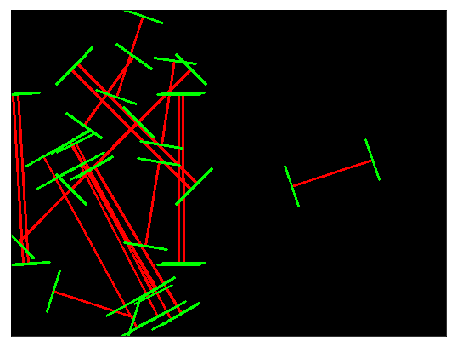

In [127]:

lines = np.array([
    # Intercecting line segments with high angle
    [0.25 * np.pi, 200, 88, 200, 0], 
    [0.75 * np.pi, -10, 200, 200, 0],

    # Intercecting line segments with high angle
    [0.25 * np.pi, 200, 0, 200, 0], 
    [0.75 * np.pi, 0, 200, 200, 0],

    # Intercecting line segments 0.03
    [0.83 * np.pi, 20, 270, 200, 0], 
    [0.85 * np.pi, 3, 275, 200, 0],

    # Segments of the same line
    [0.05 * np.pi, 200, 80, 100, 0], 
    [0.05 * np.pi, 200, 200, 100, 0],

    # Parallel close to each other 0.15
    [0.001 * np.pi, 198, 200, 200, 0], 
    [0.998 * np.pi, -202, 200, 200, 0],

    # Connected lines 2.4
    #[0.11 * np.pi, 150, 10, 100, 0], 
    #[0.06 * np.pi, 138, 128, 100, 0],

    # Parallel with positive and negative RHO
    [0.98 * np.pi, -2, 200, 200, 0], 
    [0.98 * np.pi, 4, 200, 200, 0],

    # Parallel close to each other 0.15
    [0.84 * np.pi, 10, 300, 200, 0], 
    [0.84 * np.pi, 13, 270, 200, 0],

    # Parallel with shift 0.15
    [0.84 * np.pi, 10, 300, 200, 0], 
    [0.84 * np.pi, 50, 270, 200, 0],

    # Orthoganal lines 2.4
    [0.1 * np.pi, 150, 10, 100, 0], 
    [0.6 * np.pi, 300, -200, 100, 0],

    # Parallel 0.05
    [0.84 * np.pi, 10, 310, 200, 0], 
    [0.84 * np.pi, 50, 300, 200, 0],

    # Simmetric line segments 0.05
    [0.83 * np.pi, 10, 310, 200, 0], 
    [0.85 * np.pi, 10, 300, 200, 0],

    # Faraway lines 1.6
    [0.2 * np.pi, 150, 10, 100, 0], 
    [0.4 * np.pi, 300, -300, 100, 0]
])

timg = np.zeros((384, 512, 3), dtype = np.uint8)
h, w = timg.shape[0:2]

color = (255, 0, 0)
for l in lines:
    theta, rho, eps, delta = l[0:4]
    x1, y1 = FromCartesian(theta, rho, eps - delta/2)
    x2, y2 = FromCartesian(theta, rho, eps + delta/2)
    cv2.line(timg, (x1, y1), (x2, y2), color, 2)

perps = Perpendiculars(lines)

color = (0, 255, 0)
for p in perps:
    theta, rho, eps, delta = p[0:4]
    x1, y1 = FromCartesian(theta, rho, eps - delta/2)
    x2, y2 = FromCartesian(theta, rho, eps + delta/2)
    #print(theta, rho, eps, delta)
    #print(x1, y1, x2, y2)
    cv2.line(timg, (x1, y1), (x2, y2), color, 2)


plot_img(timg, show=True)

1.0 2.36


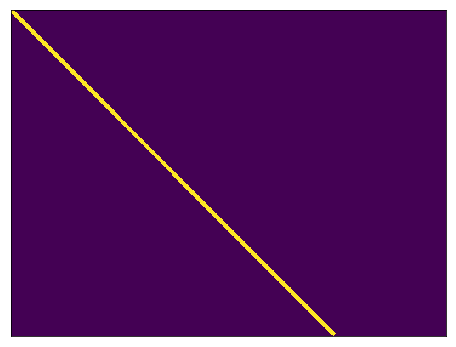

Zero dots on the line: [[27.00  2.30]]
0 36 127 152
Img shape: (384, 512)
Line shape: (640,)
Points shape: (640, 2)
Zero dots on the line: [[-18.00   2.41]]
24 0 127 115
Img shape: (384, 512)
Line shape: (580,)
Points shape: (580, 2)
[[   2.36    1.00  268.41  538.82 1648.00]
 [   2.36   -1.00  270.41  538.82 1077.00]
 [   2.37   -4.00  282.59  505.61 1201.00]
 [   2.37   -2.00  208.37  416.50 1074.00]
 [   2.34    8.00  366.00  345.08  881.00]
 [   2.34    4.00  167.17  330.94  783.00]
 [   2.34    6.00  273.78  409.43  887.00]
 [   2.32   16.00  399.27  224.90  520.00]
 [   2.39  -11.00  379.44  241.87  555.00]
 [   2.39  -14.00  442.40  186.70  487.00]
 [   2.30   21.00  370.47  149.97  350.00]
 [   2.30   23.00  413.83  151.38  363.00]
 [   2.41  -24.00  460.96  103.97  274.00]]
-1 0 379 381
1 0 382 381
23 18 374 382
1 -1 290 298
133 140 381 379
-1 4 236 233
45 52 340 336
198 207 363 360
184 181 349 358
248 245 375 382
205 213 316 313
235 243 348 344
291 287 361 365


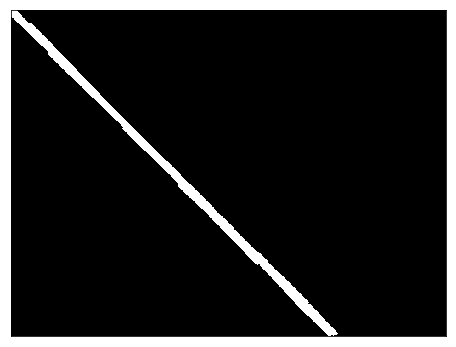

In [15]:
S_HOUGH_TR=80
S_WIDTH = 5
DBSCAN_EPS=20
DBSCAN_MIN_SAM=30
S_MINLEN=100

lines = [[1.00, 2.36]]
timg = np.zeros((384, 512), dtype=np.uint8)
h, w = timg.shape[0:2]

for rho, theta in lines:
    print(rho, theta)

    if np.pi * 0.25 < theta < np.pi * 0.75:
        x1, y1 = 0, int(rho / np.sin(theta))
        x2, y2 = w - 1, int(y1 - w * np.tan(0.5 * np.pi - theta))
    else:
        x1, y1 = int(rho / np.cos(theta)), 0
        x2, y2 = int(x1 - h * np.tan(theta)), h - 1

    res, (x1, y1), (x2, y2) = cv2.clipLine((0, 0, w-2, h-2), (x1, y1), (x2, y2))

    cv2.line(timg, (x1, y1), (x2, y2), 255, 3)

plot_img(timg, show=True)

#keys = FindSegments([lines], edges)
keys = get_contours(timg)
print(keys)

timg = np.zeros((384, 512, 3), dtype=np.uint8)
for s in keys:
        theta, rho, eps, delta = s[0:4]
        x1, y1 = FromCartesian(theta, rho, eps - delta/2)
        x2, y2 = FromCartesian(theta, rho, eps + delta/2)
        print(x1, y1, x2, y2)
        cv2.line(timg, (x1, y1), (x2, y2), (255, 255, 255), 3)

plot_img(timg, show=True)


In [315]:
a = np.array([1,2,3])
print(a.shape)
b = np.reshape(a, (1,3))
print(b.shape)
print(b)


(3,)
(1, 3)
[[1 2 3]]
